# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist



# magic word for producing visualizations in notebook
%matplotlib inline

c:\Users\avadi\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

c:\Users\avadi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
azdias_cols = azdias.columns.tolist()
customers_cols = customers.columns.tolist()

Check columns in Azdias and Customers databases

In [4]:
# We want to make sure that the columns in both the datasets are the same (besides the customer specific cols
# 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE' columns).
cols1 = customers_cols
for i in ['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']:
    cols1.remove(i)

cols2 = azdias_cols
cols1.sort() 
cols2.sort() 

if cols1 == cols2: 
    print ("The lists 1 and 2 are the same") 
else: 
    print ("not equal") 


The lists 1 and 2 are the same


Upon looking into the amount of data we have for both - the population of Germany and customer base of the mail order sales company, it appears that nearly 21% of Germany's population is a customer of the company

In [5]:
azdias.shape

(891221, 366)

In [6]:
customers.shape

(191652, 369)

In [7]:
customers.shape[0]/azdias.shape[0]

0.21504430438690292

Understandaing NaN values : We first need to get an idea of how many missing values this dataset contains. We have created a function that describes that replaces 9s, 0s and -1s in certain columns mentioned in the excel file "DIAS Attributes_unkowns.xlsx" And replaces them with NaNs.

In [8]:
# The following cell take the items from the excel file we created and detects columns with unknown values
# in the form of (0,-1 & 9) and changes these to NaN to simplify pre-processing.
def get_all_nans(df):
    '''
    Returns a df resplacing the 0s,-1s and 9s stated in the excel with NaN to keep things consistent

    Input: df in raw format
    Output: df with nans placed appropratiely
    '''
    wb2 = load_workbook("DIAS Attributes_unkowns.xlsx")  # Work Book

    Unk_1 = wb2.get_sheet_by_name('-1_Unk')  # Work Sheet with feature names that have -1 for unkowns
    Unk_1_col = Unk_1['A']  # Column 

    Unk_0 = wb2.get_sheet_by_name('0_Unk')  # Work Sheet with feature names that have 0 for unkowns
    Unk_0_col = Unk_0['A']  # Column

    Unk_9 = wb2.get_sheet_by_name('9_Unk')  # Work Sheet with feature names that have 9 for unkowns
    Unk_9_col = Unk_9['A']  # Column

        
    Unk_1_list = [Unk_1_col[x].value for x in range(len(Unk_1_col))]

    Unk_0_list = [Unk_0_col[x].value for x in range(len(Unk_0_col))]

    Unk_9_list = [Unk_9_col[x].value for x in range(len(Unk_9_col))]

    df1 = df.copy()

    df1[Unk_1_list] = df[Unk_1_list].replace(-1, np.nan)
    df1[Unk_0_list] = df[Unk_0_list].replace(0, np.nan)
    df1[Unk_9_list] = df[Unk_9_list].replace(9, np.nan)

    return df1

In [9]:
azdias_clean1 = get_all_nans(azdias)
azdias_clean1.head(5)

<ipython-input-8-f19956207524>:12: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_1 = wb2.get_sheet_by_name('-1_Unk')  # Work Sheet with feature names that have -1 for unkowns
<ipython-input-8-f19956207524>:15: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_0 = wb2.get_sheet_by_name('0_Unk')  # Work Sheet with feature names that have 0 for unkowns
<ipython-input-8-f19956207524>:18: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_9 = wb2.get_sheet_by_name('9_Unk')  # Work Sheet with feature names that have 9 for unkowns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [10]:
cust_clean1 = get_all_nans(customers)
cust_clean1.head(5)

<ipython-input-8-f19956207524>:12: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_1 = wb2.get_sheet_by_name('-1_Unk')  # Work Sheet with feature names that have -1 for unkowns
<ipython-input-8-f19956207524>:15: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_0 = wb2.get_sheet_by_name('0_Unk')  # Work Sheet with feature names that have 0 for unkowns
<ipython-input-8-f19956207524>:18: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_9 = wb2.get_sheet_by_name('9_Unk')  # Work Sheet with feature names that have 9 for unkowns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


<AxesSubplot:>

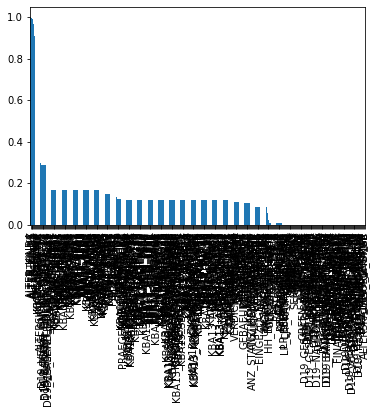

In [11]:
azdias_clean1.isnull().mean().sort_values(ascending=False).plot(kind = "bar")

In [12]:
azdias_clean1.isnull().mean().sort_values(ascending=False).head(15)

ALTER_KIND4                  0.998648
TITEL_KZ                     0.997576
ALTER_KIND3                  0.993077
ALTER_KIND2                  0.966900
ALTER_KIND1                  0.909048
AGER_TYP                     0.760196
EXTSEL992                    0.733996
KK_KUNDENTYP                 0.655967
KBA05_BAUMAX                 0.534687
GEBURTSJAHR                  0.440203
ALTER_HH                     0.348137
ALTERSKATEGORIE_FEIN         0.295041
D19_VERSI_ONLINE_QUOTE_12    0.288495
D19_LOTTO                    0.288495
D19_TELKO_ONLINE_QUOTE_12    0.288495
dtype: float64

<AxesSubplot:>

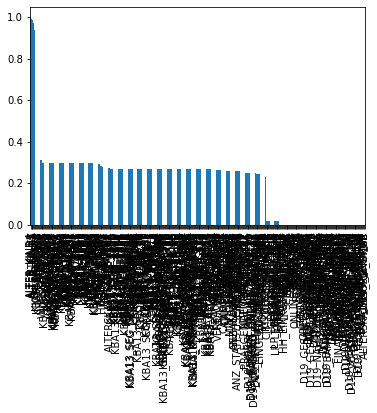

In [13]:
cust_clean1.isnull().mean().sort_values(ascending=False).plot(kind = "bar")

In [14]:
cust_clean1.isnull().mean().sort_values(ascending=False).head(15)

ALTER_KIND4       0.998769
ALTER_KIND3       0.993347
TITEL_KZ          0.987936
ALTER_KIND2       0.973389
ALTER_KIND1       0.938607
KK_KUNDENTYP      0.584064
KBA05_BAUMAX      0.571531
GEBURTSJAHR       0.485380
AGER_TYP          0.480595
EXTSEL992         0.444989
ALTER_HH          0.358707
REGIOTYP          0.313401
KKK               0.313401
W_KEIT_KIND_HH    0.297085
KBA05_AUTOQUOT    0.296965
dtype: float64

The raw dataset that we are presented with has 366 features. Features have been dropped due to one of the following:
1. They are irrelevant to our exercise
2. Exceed the acceptable NaN threshold we have set 
3. After performing a correlation analysis it was found that a lot of these features were heavily correlated to each other due to which it was essential we dropped some of them to avoid multi collinearity.



In [15]:
def drop_feats_1_2(df, threshold):
    '''
    Objective:
        Drops features due to irrelevance or excess NaNs
    Inputs: 
        df: dataframe to convert
        threshold: % NaN tolerance threshold
    Output: 
        df after removing feats
    '''
    df1 = df.copy()
    
    # Keeping columns where null values are under 34%
    df1 = df1.loc[:, df1.isnull().mean() < threshold]
    
    # dropping the 'D19_LETZTER_KAUF_BRANCHE' column as columns "['D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE','D19_SONSTIGE', 'D19_TECHNIK', 
    # 'D19_TELKO_MOBILE', 'D19_TELKO_REST', 'D19_TIERARTIKEL', 'D19_VERSAND_REST', 'D19_VERSICHERUNGEN', 'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST']" already exist
    # and making this feature redundant 
    # Also dropping other redundant features 
    df1 = df1.drop(columns=['LNR','EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','D19_LETZTER_KAUF_BRANCHE'],axis = 1)
    
    # dropping rows with strange values 
    df1 = df1[df1.CAMEO_INTL_2015!='XX']

    return df1

In [16]:
def convert2num(df):
    '''
    Objective:
        Maintain consistency in feature type and converts all features to numerical ones in the df.
    Inputs: 
        df: dataframe to convert
    Output: 
        df after removing highly-collinear features
    '''
    df1 = df.copy()
    if 'PRODUCT_GROUP' in df1.columns and 'CUSTOMER_GROUP' in df1.columns:
        # Categorical codes encoding
        df1['PRODUCT_GROUP'] = df1.PRODUCT_GROUP.astype("category").cat.codes
        df1['CUSTOMER_GROUP'] = df1.CUSTOMER_GROUP.astype("category").cat.codes
        df1['OST_WEST_KZ'] = df1.OST_WEST_KZ.astype("category").cat.codes
        # Frequency Encoding for the CAMEO_DEU_2015
        fe = df1.groupby('CAMEO_DEU_2015').size()/len(df1)
        df1.loc[:,'CAMEO_DEU_2015'] = df1['CAMEO_DEU_2015'].map(fe)
        # Convert to numeric values 
        df1['CAMEO_DEUG_2015'] = pd.to_numeric(df1['CAMEO_DEUG_2015'])    
        df1['CAMEO_INTL_2015'] = pd.to_numeric(df1['CAMEO_INTL_2015'])
    else:
        # Categorical codes encoding
        df1['OST_WEST_KZ'] = df1.OST_WEST_KZ.astype("category").cat.codes
        # Frequency Encoding for the CAMEO_DEU_2015
        fe = df1.groupby('CAMEO_DEU_2015').size()/len(df1)
        df1.loc[:,'CAMEO_DEU_2015'] = df1['CAMEO_DEU_2015'].map(fe)
        # Convert to numeric values
        df1['CAMEO_DEUG_2015'] = pd.to_numeric(df1['CAMEO_DEUG_2015'])    
        df1['CAMEO_INTL_2015'] = pd.to_numeric(df1['CAMEO_INTL_2015'])    
    return df1

In [17]:

# Function inspired by this thread 
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

def drop_feats_3(df, threshold):
    '''
    Objective:
        Remove features in a dataframe with that are highly correlated with other features in the df.
        If corr is greater than the "threshold" correlation coefficient between two features, one of them is dropped.
        This helps reduce collinearity of features improves model prtfromance.

    Inputs: 
        df: dataframe
        threshold: the amount of correlation that removes a feature from the df

    Output: 
        df after removing highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = df.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    df = df.drop(columns=drops)

    return df

Applying this to Azdias and Customer dataset

In [18]:
azdias_clean1 = drop_feats_1_2(azdias_clean1, threshold = 0.34)
#azdias_clean1 = azdias_clean1.dropna()

In [19]:
print(azdias_clean1.shape[0]*100/(azdias.shape[0]),"%", "of the data has been retained after dropping NaNs")

99.95814730577489 % of the data has been retained after dropping NaNs


In [20]:
cust_clean1 = drop_feats_1_2(cust_clean1, threshold=0.33)
#cust_clean1 = cust_clean1.dropna()

In [21]:
print(cust_clean1.shape[0]*100/(customers.shape[0]),"%", "of the data has been retained after dropping NaNs")

99.93425583870766 % of the data has been retained after dropping NaNs


In [22]:
for col in cust_clean1:
    if cust_clean1[col].dtypes != "int64" and cust_clean1[col].dtypes != "float" and cust_clean1[col].dtypes != "int8":
        print(col)

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
OST_WEST_KZ
PRODUCT_GROUP
CUSTOMER_GROUP


Convert all the columns to numeric variables by applying encoding

In [23]:
azdias_clean1 = convert2num(azdias_clean1)
cust_clean1 = convert2num(cust_clean1)

In [24]:
azdias_clean1 = drop_feats_3(azdias_clean1, threshold=0.70)

ANZ_STATISTISCHE_HAUSHALTE | ANZ_HAUSHALTE_AKTIV | 0.98
CAMEO_INTL_2015 | CAMEO_DEUG_2015 | 0.96
CJT_TYP_2 | CJT_TYP_1 | 0.9
CJT_TYP_4 | CJT_TYP_3 | 0.76
CJT_TYP_5 | CJT_TYP_3 | 0.76
CJT_TYP_5 | CJT_TYP_4 | 0.72
D19_BANKEN_ANZ_24 | D19_BANKEN_ANZ_12 | 0.82
D19_BANKEN_DATUM | D19_BANKEN_ANZ_12 | 0.75
D19_BANKEN_DATUM | D19_BANKEN_ANZ_24 | 0.81
D19_BANKEN_ONLINE_DATUM | D19_BANKEN_ANZ_12 | 0.71
D19_BANKEN_ONLINE_DATUM | D19_BANKEN_ANZ_24 | 0.77
D19_BANKEN_ONLINE_DATUM | D19_BANKEN_DATUM | 0.89
D19_BANKEN_ONLINE_QUOTE_12 | D19_BANKEN_ANZ_12 | 0.79
D19_BANKEN_ONLINE_QUOTE_12 | D19_BANKEN_DATUM | 0.74
D19_BANKEN_ONLINE_QUOTE_12 | D19_BANKEN_ONLINE_DATUM | 0.85
D19_GESAMT_ANZ_24 | D19_GESAMT_ANZ_12 | 0.91
D19_GESAMT_DATUM | D19_GESAMT_ANZ_12 | 0.82
D19_GESAMT_DATUM | D19_GESAMT_ANZ_24 | 0.87
D19_GESAMT_ONLINE_DATUM | D19_GESAMT_ANZ_12 | 0.81
D19_GESAMT_ONLINE_DATUM | D19_GESAMT_ANZ_24 | 0.85
D19_GESAMT_ONLINE_DATUM | D19_GESAMT_DATUM | 0.89
D19_GESAMT_ONLINE_QUOTE_12 | D19_GESAMT_ANZ_12 | 0.

In [33]:
azdias_clean_clust = azdias_clean1.dropna()

In [34]:
azdias_clean_clust.head(10)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP
2,9.0,17.0,10.0,0.0,0.0,1.0,0.0,3.0,2.0,0.053678,...,5.0,0.0,1.0,1.0,0.0,2.0,3.0,9.0,2.0,5
4,1.0,14.0,3.0,0.0,0.0,4.0,0.0,4.0,2.0,0.063616,...,3.0,0.0,1.0,2.0,0.0,2.0,2.0,9.0,3.0,4
5,1.0,10.0,5.0,0.0,0.0,1.0,0.0,2.0,6.0,0.034790,...,3.0,0.0,0.0,2.0,0.0,2.0,6.0,9.0,7.0,4
7,1.0,14.0,6.0,0.0,0.0,1.0,0.0,2.0,2.0,0.039371,...,4.0,0.0,3.0,1.0,0.0,2.0,5.0,9.0,1.0,1
9,5.0,17.0,9.0,0.0,0.0,1.0,0.0,2.0,6.0,0.005686,...,5.0,0.0,23.0,2.0,0.0,4.0,4.0,3.0,7.0,4
10,1.0,10.0,6.0,0.0,0.0,1.0,0.0,4.0,6.0,0.032096,...,3.0,0.0,0.0,2.0,0.0,4.0,6.0,9.0,5.0,3
27,6.0,16.0,6.0,0.0,1.0,2.0,0.0,4.0,1.0,0.031067,...,5.0,0.0,3.0,2.0,0.0,3.0,1.0,3.0,3.0,4
32,4.0,18.0,1.0,0.0,0.0,2.0,0.0,4.0,6.0,0.004570,...,4.0,1.0,0.0,1.0,5.0,3.0,6.0,9.0,7.0,1
33,1.0,14.0,3.0,0.0,0.0,4.0,0.0,3.0,1.0,0.037531,...,5.0,0.0,4.0,2.0,2.0,1.0,4.0,9.0,1.0,3
37,1.0,13.0,1.0,0.0,0.0,3.0,0.0,3.0,6.0,0.053678,...,5.0,0.0,0.0,2.0,0.0,2.0,2.0,9.0,4.0,1


In [37]:
cust_clean_clust = cust_clean1[azdias_clean_clust.columns.tolist()]
cust_clean_clust = cust_clean_clust.dropna()
cust_clean_clust.head(10)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP
0,1.0,10.0,1.0,0.0,0.0,2.0,0.0,1.0,3.0,0.021919,...,4.0,0.0,8.0,1.0,0.0,3.0,6.0,9.0,7.0,3
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,7.0,0.023736,...,5.0,0.0,0.0,2.0,0.0,4.0,6.0,9.0,2.0,3
4,1.0,14.0,7.0,0.0,0.0,4.0,0.0,3.0,3.0,0.017862,...,4.0,0.0,1.0,2.0,0.0,4.0,2.0,9.0,3.0,1
5,1.0,10.0,1.0,0.0,0.0,2.0,0.0,3.0,7.0,0.023736,...,5.0,0.0,24.0,2.0,5.0,4.0,6.0,9.0,1.0,2
6,1.0,10.0,1.0,0.0,0.0,2.0,0.0,2.0,6.0,0.009257,...,5.0,0.0,0.0,1.0,0.0,4.0,6.0,9.0,7.0,1
7,1.0,9.0,1.0,0.0,0.0,2.0,0.0,3.0,5.0,0.030701,...,4.0,0.0,0.0,1.0,1.0,3.0,6.0,9.0,3.0,3
9,1.0,13.0,1.0,0.0,0.0,3.0,0.0,3.0,2.0,0.030701,...,5.0,0.0,4.0,2.0,0.0,2.0,2.0,9.0,5.0,1
11,1.0,10.0,1.0,0.0,0.0,1.0,0.0,2.0,6.0,0.058519,...,5.0,0.0,0.0,1.0,1.0,3.0,6.0,3.0,4.0,1
12,1.0,14.0,1.0,0.0,0.0,3.0,0.0,1.0,6.0,0.039196,...,4.0,0.0,0.0,1.0,0.0,3.0,4.0,9.0,7.0,1
15,5.0,12.0,1.0,0.0,0.0,5.0,0.0,3.0,2.0,0.030701,...,5.0,0.0,1.0,2.0,0.0,3.0,2.0,9.0,2.0,1


In [ ]:
customers.columns

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Data Exploration

<AxesSubplot:ylabel='PRODUCT_GROUP'>

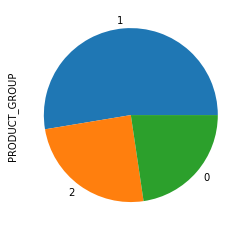

In [39]:
cust_clean1.PRODUCT_GROUP.value_counts(normalize=True).plot.pie()

In [75]:
def viz_cluster(pred_az = az_clusts, pred_cus = cus_clusts):
    '''
    '''
    
    # number of clusters in the data
    num_clusters = len(np.unique(pred_az))

    # Occurances of each cluster
    pred_az_counts = np.bincount(pred_az, minlength=num_clusters)
    pred_cus_counts = np.bincount(pred_cus, minlength=num_clusters)

    # % representation of cluster
    az_clust_perc = pred_az_counts / np.sum(pred_az_counts)
    cus_clust_perc = pred_cus_counts / np.sum(pred_cus_counts)

    # figure and plot

    cluster_indices = np.arange(num_clusters)

    plt.figure(figsize=(10, 5))
    plt.bar(cluster_indices - 0.2, az_clust_perc, width=0.4, label='Azdias', alpha=0.8)
    plt.bar(cluster_indices + 0.2, cus_clust_perc, width=0.4, label='Customer', alpha=0.8)

    # Customize the plot
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.title('Cluster Representation in Train and Other Data')
    plt.xticks(cluster_indices, cluster_indices)
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()

# Usage example:
# Assuming 'predicted_train' and 'predicted_other' are arrays containing the predicted cluster labels
# from the KMeans clustering on the train and other datasets, respectively.

# visualize_cluster_representation(predicted_train, predicted_other)

viz_cluster(az_clusts, cus_clusts)






def createhist(col, df1=azdias_clean, df2=cust_clean):

    x = df1[col].unique().tolist()
    x.sort()
    x

    f, ax = plt.subplots(figsize=(15,8))
    df1[col].value_counts(normalize=True).loc[x].plot.bar(width = 1)
    ax.set_title("Azdias - "+col)

    f, ax = plt.subplots(figsize=(15,8))
    df2[col].value_counts(normalize=True).loc[x].plot.bar(width = 1)
    ax.set_title("Customers - "+col)



CAMEO_DEUG_2015 - CAMEO classification 2015 - Uppergroup
- 1:upper class
- 2:upper middleclass
- 3:established middleclasse
- 4:consumption-oriented middleclass 
- 5:active middleclass 
- 6:low-consumption middleclass
- 7:lower middleclass
- 8:working class
- 9:urban working class


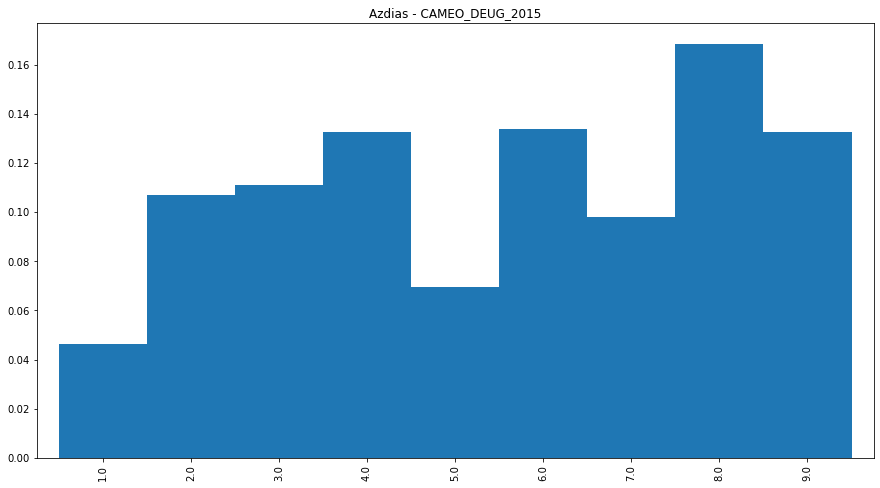

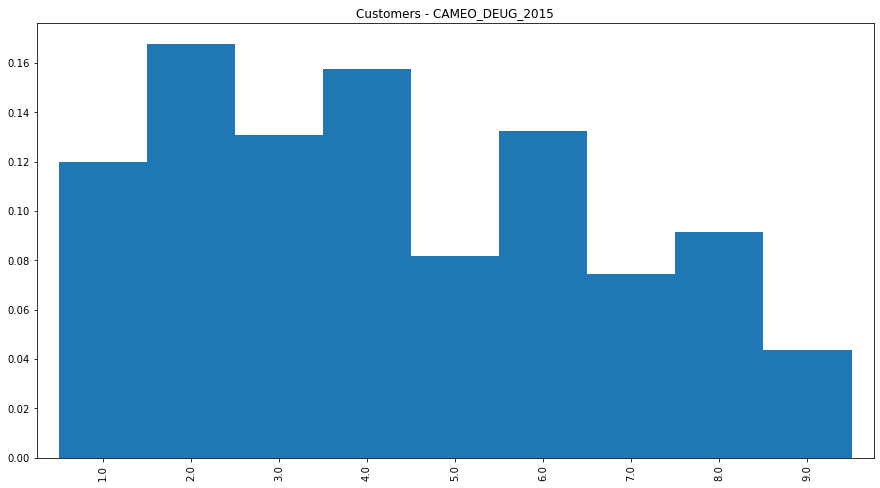

In [76]:
createhist('CAMEO_DEUG_2015')

### Unsupervised learning

In [54]:
#
azdias_clean1 = remove_multicollinearity(azdias_clean1, threshold=0.70)


ANZ_STATISTISCHE_HAUSHALTE | ANZ_HAUSHALTE_AKTIV | 0.99
CAMEO_INTL_2015 | CAMEO_DEUG_2015 | 0.96
CJT_TYP_2 | CJT_TYP_1 | 0.89
CJT_TYP_3 | CJT_TYP_1 | 0.83
CJT_TYP_3 | CJT_TYP_2 | 0.85
CJT_TYP_4 | CJT_TYP_1 | 0.77
CJT_TYP_4 | CJT_TYP_2 | 0.76
CJT_TYP_4 | CJT_TYP_3 | 0.73
CJT_TYP_5 | CJT_TYP_1 | 0.84
CJT_TYP_5 | CJT_TYP_2 | 0.82
CJT_TYP_5 | CJT_TYP_3 | 0.77
CJT_TYP_5 | CJT_TYP_4 | 0.73
CJT_TYP_6 | CJT_TYP_1 | 0.72
CJT_TYP_6 | CJT_TYP_2 | 0.71
D19_BANKEN_ANZ_24 | D19_BANKEN_ANZ_12 | 0.81
D19_BANKEN_DATUM | D19_BANKEN_ANZ_12 | 0.75
D19_BANKEN_DATUM | D19_BANKEN_ANZ_24 | 0.8
D19_BANKEN_ONLINE_DATUM | D19_BANKEN_ANZ_24 | 0.75
D19_BANKEN_ONLINE_DATUM | D19_BANKEN_DATUM | 0.88
D19_BANKEN_ONLINE_QUOTE_12 | D19_BANKEN_ANZ_12 | 0.79
D19_BANKEN_ONLINE_QUOTE_12 | D19_BANKEN_DATUM | 0.74
D19_BANKEN_ONLINE_QUOTE_12 | D19_BANKEN_ONLINE_DATUM | 0.85
D19_GESAMT_ANZ_24 | D19_GESAMT_ANZ_12 | 0.89
D19_GESAMT_DATUM | D19_GESAMT_ANZ_12 | 0.79
D19_GESAMT_DATUM | D19_GESAMT_ANZ_24 | 0.82
D19_GESAMT_ONLINE_DATU

In [55]:
azdias_clean1.head(5)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP
2,9.0,17.0,10.0,0.0,0.0,1.0,0.0,3.0,2.0,0.066374,...,0.0,1.0,1.0,0.0,2.0,9.0,3.0,9.0,2.0,5
4,1.0,14.0,3.0,0.0,0.0,4.0,0.0,4.0,2.0,0.075878,...,0.0,1.0,2.0,0.0,2.0,3.0,2.0,9.0,3.0,4
5,1.0,10.0,5.0,0.0,0.0,1.0,0.0,2.0,6.0,0.041435,...,0.0,0.0,2.0,0.0,2.0,10.0,6.0,9.0,7.0,4
7,1.0,14.0,6.0,0.0,0.0,1.0,0.0,2.0,2.0,0.051160,...,0.0,3.0,1.0,0.0,2.0,10.0,5.0,9.0,1.0,1
9,5.0,17.0,9.0,0.0,0.0,1.0,0.0,2.0,6.0,0.007612,...,0.0,23.0,2.0,0.0,4.0,1.0,4.0,3.0,7.0,4


In [56]:
cust_clean_clust = cust_clean1[azdias_clean1.columns.tolist()]

In [57]:
cust_clean_clust.head(5)

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,...,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP
0,1.0,10.0,1.0,0.0,0.0,2.0,0.0,1.0,3.0,0.031185,...,0.0,8.0,1.0,0.0,3.0,5.0,6.0,9.0,7.0,3
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,7.0,0.032839,...,0.0,0.0,2.0,0.0,4.0,10.0,6.0,9.0,2.0,3
4,1.0,14.0,7.0,0.0,0.0,4.0,0.0,3.0,3.0,0.023241,...,0.0,1.0,2.0,0.0,4.0,3.0,2.0,9.0,3.0,1
5,1.0,10.0,1.0,0.0,0.0,2.0,0.0,3.0,7.0,0.032839,...,0.0,24.0,2.0,5.0,4.0,1.0,6.0,9.0,1.0,2
6,1.0,10.0,1.0,0.0,0.0,2.0,0.0,2.0,6.0,0.010335,...,0.0,0.0,1.0,0.0,4.0,3.0,6.0,9.0,7.0,1


In [84]:
#################

Scaling

In [114]:
scaler = preprocessing.StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_clean1)) #scaling the data

In [129]:
cust_scaled = pd.DataFrame(scaler.fit_transform(cust_clean_clust))

Principal Component Analysis

<Figure size 2520x288 with 0 Axes>

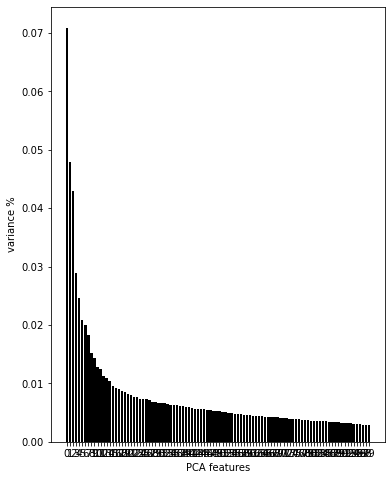

In [95]:
# Create a PCA instance: pca
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(scaled_data)
# Plot the explained variances
features = range(pca.n_components_)
plt.figure().set_figwidth(35)
plt.figure().set_figheight(8)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

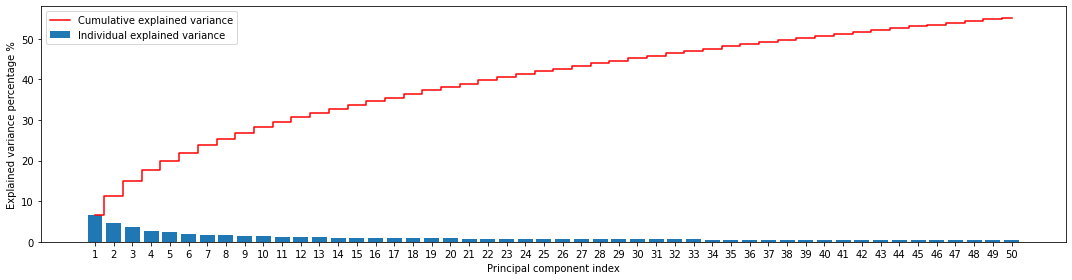

In [123]:
pca = PCA(n_components=50)
pca.fit(azdias_scaled)
principalComponents = pca.fit_transform(azdias_scaled)

exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)


a = 50 + 1

plt.figure().set_figwidth(15)
#plt.figure().set_figheight(3)

plt.bar(range(1, a), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, a), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')
plt.ylabel('Explained variance percentage %')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, a)))
plt.legend(loc='best')
plt.tight_layout()

#plt.savefig("cumulative explained variance plot.png")

In [127]:
PCA_components.iloc[:,:10]

,0,1,2,3,4,5,6,7,8,9
0,0.070317,0.583766,-0.122850,0.512672,0.966765,0.440720,-1.274669,0.923503,-0.298102,-0.264296
1,0.336289,0.717221,-0.467406,0.536608,-0.764189,0.946951,0.304590,0.365211,0.254288,1.178784
2,0.224653,0.634798,-0.017925,-0.865017,0.978759,0.073492,0.159873,0.382538,-0.112808,0.035030
3,0.510603,0.744218,0.267827,-0.674950,0.860195,1.024003,0.838351,0.695661,-0.607316,-0.909745
4,1.984525,2.271826,-0.542337,1.451875,0.710577,-0.058621,-0.958015,0.635602,0.580726,0.544992
...,...,...,...,...,...,...,...,...,...,...
424060,-1.652421,0.677893,-0.818334,0.162781,-0.294498,0.843477,-0.662944,1.082276,0.213616,0.808954
424061,-1.952614,-0.133680,0.356655,-0.960793,-0.183944,0.223386,-0.377268,-0.237044,0.009181,-0.532478
424062,1.768609,-0.325462,-1.002680,1.319815,-1.173019,-1.028535,0.148471,-0.282405,0.409096,-0.185120
424063,-0.998437,0.895791,-1.077915,-0.786445,-0.083620,-0.475280,-0.163994,-1.285312,-0.046328,0.445187


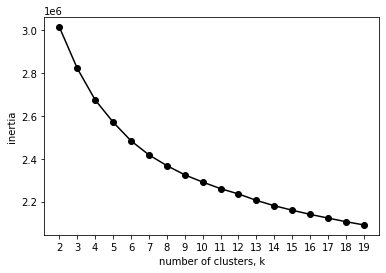

In [128]:
ks = range(2, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:20])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [130]:
kmeans = KMeans(n_clusters = 6, random_state = 150)
    
# Fitting to azdias data:
kmeans.fit(azdias_scaled)
    
# clusters on azdias:
az_clusts = kmeans.predict(azdias_scaled)
    
# Predicting clusters on customers:
cus_clusts = kmeans.predict(cust_scaled)

In [ ]:
az_clusts

array([3, 1, 4, ..., 4, 1, 1])

In [ ]:
cus_clusts

array([0, 2, 1, ..., 3, 2, 4])

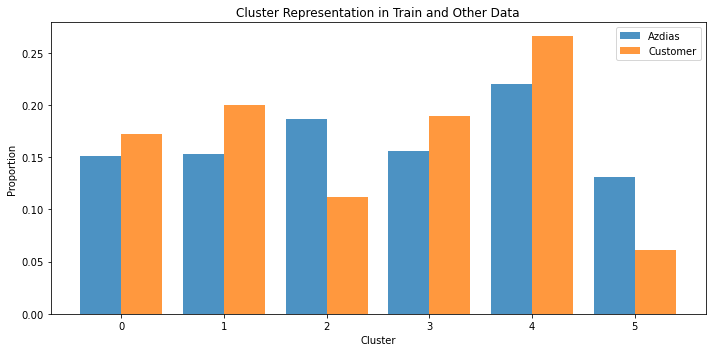

In [131]:
def viz_cluster(pred_az = az_clusts, pred_cus = cus_clusts):
    '''
    '''
    
    # number of clusters in the data
    num_clusters = len(np.unique(pred_az))

    # Occurances of each cluster
    pred_az_counts = np.bincount(pred_az, minlength=num_clusters)
    pred_cus_counts = np.bincount(pred_cus, minlength=num_clusters)

    # % representation of cluster
    az_clust_perc = pred_az_counts / np.sum(pred_az_counts)
    cus_clust_perc = pred_cus_counts / np.sum(pred_cus_counts)

    # figure and plot

    cluster_indices = np.arange(num_clusters)

    plt.figure(figsize=(10, 5))
    plt.bar(cluster_indices - 0.2, az_clust_perc, width=0.4, label='Azdias', alpha=0.8)
    plt.bar(cluster_indices + 0.2, cus_clust_perc, width=0.4, label='Customer', alpha=0.8)

    # Customize the plot
    plt.xlabel('Cluster')
    plt.ylabel('Proportion')
    plt.title('Cluster Representation in Train and Other Data')
    plt.xticks(cluster_indices, cluster_indices)
    plt.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()

# Usage example:
# Assuming 'predicted_train' and 'predicted_other' are arrays containing the predicted cluster labels
# from the KMeans clustering on the train and other datasets, respectively.

# visualize_cluster_representation(predicted_train, predicted_other)

viz_cluster(az_clusts, cus_clusts)

In [133]:
# Cluster 1

azdias_clean1

In [134]:
def find_prominent_features(data, cluster_labels):
    # Create a DataFrame with data and cluster labels
    df = pd.DataFrame(data)
    df['Cluster'] = cluster_labels

    # Calculate the overall mean for each feature in the entire dataset
    overall_feature_means = df.drop('Cluster', axis=1).mean()

    # Group the data by cluster and calculate the mean for each cluster
    cluster_means = df.groupby('Cluster').mean()

    # Calculate the relative difference between cluster means and overall means
    relative_diff = cluster_means - overall_feature_means

    # Identify prominent features by finding those with the highest relative difference
    prominent_features_per_cluster = {}
    for cluster in relative_diff.index:
        cluster_features = relative_diff.loc[cluster]
        prominent_features = cluster_features.abs().nlargest(5).index.tolist()
        prominent_features_per_cluster[cluster] = prominent_features

    return prominent_features_per_cluster

# Assuming 'data' contains your dataset and 'cluster_labels' contains the predicted cluster labels from KMeans
prominent_features = find_prominent_features(azdias_clean1, az_clusts)

# Print the prominent features for each cluster
for cluster, features in prominent_features.items():
    print(f"Cluster {cluster}: Prominent Features - {features}")


Cluster 0: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'VK_DHT4A', 'D19_HAUS_DEKO']
Cluster 1: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEUG_2015']
Cluster 2: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEUG_2015']
Cluster 3: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'KBA13_KW_121', 'KBA13_SEG_SPORTWAGEN']
Cluster 4: Prominent Features - ['KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'ANZ_HAUSHALTE_AKTIV', 'VERDICHTUNGSRAUM', 'CAMEO_DEUG_2015']
Cluster 5: Prominent Features - ['KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'ANZ_HAUSHALTE_AKTIV', 'KBA13_SITZE_4', 'KBA13_SEG_OBEREMITTELKLASSE']


In [135]:
prominent_features = find_prominent_features(cust_clean_clust, cus_clusts)

# Print the prominent features for each cluster
for cluster, features in prominent_features.items():
    print(f"Cluster {cluster}: Prominent Features - {features}")


Cluster 0: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'VK_DHT4A', 'D19_HAUS_DEKO']
Cluster 1: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEUG_2015']
Cluster 2: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ALTERSKATEGORIE_FEIN', 'CAMEO_DEUG_2015']
Cluster 3: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'KBA13_KW_121', 'VERDICHTUNGSRAUM', 'KBA13_CCM_2501']
Cluster 4: Prominent Features - ['KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'ANZ_HAUSHALTE_AKTIV', 'VERDICHTUNGSRAUM', 'EWDICHTE']
Cluster 5: Prominent Features - ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SITZE_4']


In [103]:
prominent_features.items()

dict_items([(0, ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ALTERSKATEGORIE_FEIN']), (1, ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ALTERSKATEGORIE_FEIN']), (2, ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ALTERSKATEGORIE_FEIN']), (3, ['GEBURTSJAHR', 'KBA13_ANZAHL_PKW', 'ALTERSKATEGORIE_FEIN']), (4, ['KBA13_ANZAHL_PKW', 'GEBURTSJAHR', 'ANZ_HAUSHALTE_AKTIV'])])

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [25]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

c:\Users\avadi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
mailout_train

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,2,1.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,1.0,1.0,4.0,8.0,7.0,1,0,1,4
42958,67629,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,1.0,1.0,1.0,5.0,9.0,7.0,1,0,1,3
42959,68273,1,1.0,16.0,NaN,NaN,NaN,NaN,10.0,2.0,...,1.0,2.0,1.0,2.0,9.0,7.0,1,0,1,4
42960,68581,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,3.0,...,2.0,3.0,4.0,2.0,9.0,2.0,3,0,2,4
